In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1. 讀入深度學習套件

In [2]:
from tensorflow.keras.preprocessing import sequence # 把輸入的長度弄成一樣長
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding # Embedding：處理文字用的layer(把文字做one-hot encoding)
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.datasets import imdb

### 2. 讀入數據

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000) # num_words：常用字的數量

In [4]:
len(x_train)

25000

In [5]:
len(x_test)

25000

In [42]:
x_train[0][:10] # 出現的數字代表該字出現的頻率排名

array([  12,    8,  316,    8,  106,    5,    4, 2223, 5244,   16])

In [7]:
len(x_train[0]) # 第0號評論有幾個字

218

In [8]:
len(x_train[1]) # 第1號評論有幾個字

189

In [9]:
y_train[0] # 1 = 正評

1

In [10]:
y_train[1] # 0 = 負評

0

### 3. 資料處理

調整項目：
* maxlen 100 → 128
* 把25000筆測試集拆成15000筆驗證集和10000筆測試集，此時訓練集、驗證集和測試集的比例為5:3:2

In [11]:
### 儘管RNN的輸入可以是不定長度的，還是要先把輸入用成一樣長 ###
x_train = sequence.pad_sequences(x_train, maxlen = 128) # maxlen = 128: 低於128字補0；超過100字把超過的地方去掉
x_test = sequence.pad_sequences(x_test, maxlen = 128)

In [12]:
from sklearn.model_selection import train_test_split
x_val, x_test, y_val, y_test = train_test_split(x_test, 
                                                y_test,
                                                test_size = 0.4,
                                                random_state = 100)
print(x_val.shape, x_test.shape)
print(y_val.shape, y_test.shape)

(15000, 128) (10000, 128)
(15000,) (10000,)


In [30]:
import sklearn

In [13]:
x_train[0]

array([  12,    8,  316,    8,  106,    5,    4, 2223, 5244,   16,  480,
         66, 3785,   33,    4,  130,   12,   16,   38,  619,    5,   25,
        124,   51,   36,  135,   48,   25, 1415,   33,    6,   22,   12,
        215,   28,   77,   52,    5,   14,  407,   16,   82,    2,    8,
          4,  107,  117, 5952,   15,  256,    4,    2,    7, 3766,    5,
        723,   36,   71,   43,  530,  476,   26,  400,  317,   46,    7,
          4,    2, 1029,   13,  104,   88,    4,  381,   15,  297,   98,
         32, 2071,   56,   26,  141,    6,  194, 7486,   18,    4,  226,
         22,   21,  134,  476,   26,  480,    5,  144,   30, 5535,   18,
         51,   36,   28,  224,   92,   25,  104,    4,  226,   65,   16,
         38, 1334,   88,   12,   16,  283,    5,   16, 4472,  113,  103,
         32,   15,   16, 5345,   19,  178,   32])

In [14]:
x_train.shape

(25000, 128)

### 4. 打造一個函數學習機
調整項目：
* LSTM改用GRU，並且降低神經元的數量(128降至64)
* 實施early stopping

In [15]:
model = Sequential() # 打開一個空白的函數學習機

In [16]:
model.add(Embedding(10000, 128)) # RNN的激發函數不需要特別設定，用預設的就好

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
model.add(GRU(64, dropout = 0.2, recurrent_dropout = 0.2))
    # dropout: 避免模型「背答案」，每次學的時候該神經層有多少比例的參數不會去學習
    # recurrent：記憶過去的訓練輸出
    # recurrent_dropout：hidden state的dropout

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
model.add(Dense(1, activation = 'sigmoid')) # 1: 輸出只有正評和負評

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) 
    # adam好處：1.比較快 2.會做momentum(讓他的動量不要做太大的改變，穩穩地走下山)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37056     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,317,121
Trainable params: 1,317,121
Non-trainable params: 0
_________________________________________________________________


**實施early stopping，即模型訓練一段時間之後，當準確率不再有顯著的提升就提早結束訓練，這樣不僅能夠節省訓練的時間，也可以防止模型過度擬合。**

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0, mode = 'auto') 
    # patience = 3: 當模型不再有顯著的進步時，還會再多訓練3個epochs才結束訓練

Using TensorFlow backend.


### 5. 訓練
調整項目：
* batch_size 32 → 64
* epochs 10 → 20 (有實施early stopping，可以設高一點)

In [22]:
history = model.fit(x_train, y_train, batch_size = 64, epochs = 20, validation_data = (x_val, y_val), 
                    callbacks = [early_stopping])

Train on 25000 samples, validate on 15000 samples
Epoch 1/20
25000/25000 [==============================] - 88s 4ms/sample - loss: 0.4903 - acc: 0.7592 - val_loss: 0.3954 - val_acc: 0.8214
Epoch 2/20
25000/25000 [==============================] - 103s 4ms/sample - loss: 0.3480 - acc: 0.8541 - val_loss: 0.3637 - val_acc: 0.8390
Epoch 3/20
25000/25000 [==============================] - 121s 5ms/sample - loss: 0.2766 - acc: 0.8890 - val_loss: 0.3615 - val_acc: 0.8483
Epoch 4/20
25000/25000 [==============================] - 134s 5ms/sample - loss: 0.2168 - acc: 0.9135 - val_loss: 0.3880 - val_acc: 0.8393
Epoch 5/20
25000/25000 [==============================] - 141s 6ms/sample - loss: 0.1746 - acc: 0.9341 - val_loss: 0.4187 - val_acc: 0.8404
Epoch 6/20
25000/25000 [==============================] - 163s 7ms/sample - loss: 0.1372 - acc: 0.9503 - val_loss: 0.4550 - val_acc: 0.8409


### 6. 訓練成果

**畫出訓練過程中訓練集和驗證集準確率和loss值的變化情形**

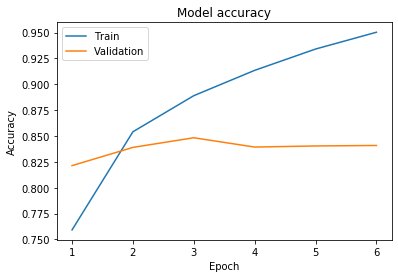

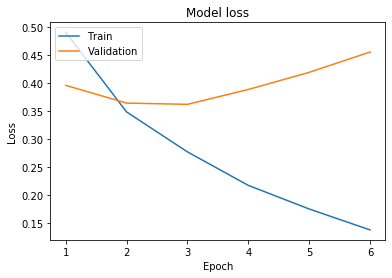

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'])
plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

從Model loss這張圖中可以看出在第四個epoch之後，驗證集的loss反而是逐漸上升的，暗指可能發生over-fitting的現象，也許未來將epochs設成3模型會有比較好的預測結果。

**查看該模型預測測試集資料的結果**

In [24]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.4285 - acc: 0.8531
Test loss: 0.42846572553515433
Test accuracy: 0.8531


目前我做出來的模型預測測試集的準確率為0.8531。

### 7. 儲存模型和模型參數

In [34]:
model.save('myRNNmodel.h5')

In [35]:
model_json = model.to_json()
open('imbd_model_architecture.json', 'w').write(model_json)
model.save_weights('imbd_model_weights.h5')

### 8. 模型比較(課堂範例 VS 經過自己調整後的模型)

**查看課堂範例建的RNN模型預測測試集資料的結果**

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model_classExample = load_model('myRNNmodel_classExample.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
score_classExample = model_classExample.evaluate(x_test, y_test)
print('Test loss:', score_classExample[0])
print('Test accuracy:', score_classExample[1])

10000/10000 [==============================] - 22s 2ms/sample - loss: 0.7193 - acc: 0.8543
Test loss: 0.7193457586705685
Test accuracy: 0.8543


用課堂範例建立的模型預測測試集的準確率為0.8543，和經過自己調整之後的模型比較(0.8531)，原本的模型預測能力還稍微好一點。